# Reading µs-ALEX data from Photon-HDF5

*In this notebook we show how to read a µs-ALEX  smFRET measurement stored in *
*[Photon-HDF5 format](http://photon-hdf5.readthedocs.org/)*
*using python and a few common scientific libraries (numpy, **pytables**, matplotlib).*
*Specifically, we show how to load timestamps, build an alternation histogram * 
*and select photons in the donor and acceptor excitation periods.*

*For a ns-ALEX example see [Reading ns-ALEX data from Photon-HDF5](Reading ns-ALEX data from Photon-HDF5.ipynb).*

In [1]:
from __future__ import division, print_function  # only needed on py2
%matplotlib inline
import numpy as np
import tables
import matplotlib.pyplot as plt

# 1. Utility functions

Here we define an utility function to print HDF5 file contents:

In [2]:
def print_children(group):
    """Print all the sub-groups in `group` and leaf-nodes children of `group`.

    Parameters:
        group (pytables group): the group to be printed.
    """
    for name, value in group._v_children.items():
        if isinstance(value, tables.Group):
            content = '(Group)'
        else:
            content = value.read()
        print(name)
        print('    Content:     %s' % content)
        print('    Description: %s\n' % value._v_title.decode())

# 2. Open the data file

Let assume we have a Photon-HDF5 file at the following location:

In [3]:
filename = '../data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

We can open the file, as a normal HDF5 file

In [4]:
h5file = tables.open_file(filename)

The object `h5file` is a pytables file reference. The root group is accessed with `h5file.root`.

# 3. Print the content

Let's start by taking a look at the file content:

In [5]:
print_children(h5file.root)

sample
    Content:     (Group)
    Description: Information about the measured sample.

setup
    Content:     (Group)
    Description: Information about the experimental setup.

identity
    Content:     (Group)
    Description: Information about the Photon-HDF5 data file.

photon_data
    Content:     (Group)
    Description: Group containing arrays of photon-data.

provenance
    Content:     (Group)
    Description: Information about the original data file.

description
    Content:     b'us-ALEX measurement of a doubly-labeled ssDNA sample.'
    Description: A user-defined comment describing the data file.

acquisition_duration
    Content:     600.0
    Description: Measurement duration in seconds.



We see the typical Photon-HDF5 structure. In particular the field `description` provides a short description of the measurement and `acquisition_duration` tells that the acquisition lasted 600 seconds.

As an example let's take a look at the content of the `sample` group:

In [6]:
print_children(h5file.root.sample)

buffer_name
    Content:     b'TE50 + 0.5M GndCl'
    Description: A descriptive name for the buffer.

sample_name
    Content:     b'20dt ssDNA oligo doubly labeled with Cy3B and Atto647N'
    Description: A descriptive name for the sample.

num_dyes
    Content:     2
    Description: Number of different dyes present in the samples.

dye_names
    Content:     b'Cy3B, ATTO647N'
    Description: String containing a comma-separated list of dye or fluorophore names.



Let's define a shortcut to the photon_data group to save some typing later:

In [7]:
photon_data = h5file.root.photon_data

# 4. Reading the data

First, we make sure the file contains the right type of measurement:

In [8]:
photon_data.measurement_specs.measurement_type.read().decode()

'smFRET-usALEX'

Ok, tha's what we espect. 

Now we can load all the timestamps (including timestamps unit) and detectors arrays:

In [9]:
timestamps = photon_data.timestamps.read()
timestamps_unit = photon_data.timestamps_specs.timestamps_unit.read()
detectors = photon_data.detectors.read()

In [10]:
print('Number of photons: %d' % timestamps.size)
print('Timestamps unit:   %.2e seconds' % timestamps_unit)
print('Detectors:         %s' % np.unique(detectors))

Number of photons: 2683962
Timestamps unit:   1.25e-08 seconds
Detectors:         [0 1]


We may want to check the excitation wavelengths used in the measurement. This information is found in the setup group:

In [11]:
h5file.root.setup.excitation_wavelengths.read()

[5.32e-07, 6.35e-07]

Now, let's load the definitions of donor/acceptor channel and excitation periods:

In [12]:
donor_ch = photon_data.measurement_specs.detectors_specs.spectral_ch1.read()
acceptor_ch = photon_data.measurement_specs.detectors_specs.spectral_ch2.read()
print('Donor CH: %d     Acceptor CH: %d' % (donor_ch, acceptor_ch))

Donor CH: 0     Acceptor CH: 1


In [13]:
alex_period = photon_data.measurement_specs.alex_period.read()
offset = photon_data.measurement_specs.alex_offset.read()
donor_period = photon_data.measurement_specs.alex_excitation_period1.read()
acceptor_period = photon_data.measurement_specs.alex_excitation_period2.read()
print('ALEX period:     %d  \nOffset:         %4d      \nDonor period:    %s      \nAcceptor period: %s' % \
      (alex_period, offset, donor_period, acceptor_period))

ALEX period:     4000  
Offset:          700      
Donor period:    [2180, 3900]      
Acceptor period: [200, 1800]


These numbers define the donor and acceptor alternation periods as shown below:

$$2180 < \widetilde{t} < 3900 \qquad \textrm{donor period}$$

$$200 < \widetilde{t} < 1800 \qquad \textrm{acceptor period}$$

where $\widetilde{t}$ represent the (`timestamps` - `offset`) **MODULO** `alex_period`.

For more information
please refer to the [measurements_specs section](http://photon-hdf5.readthedocs.org/en/latest/phdata.html#measurement-specs)
of the *Reference Documentation*.

# 5. Plotting the alternation histogram

Let start by separating timestamps from donor and acceptor channels:

In [14]:
timestamps_donor = timestamps[detectors == donor_ch]
timestamps_acceptor = timestamps[detectors == acceptor_ch]

Now that the data has been loaded we can plot an alternation histogram using *matplotlib*:

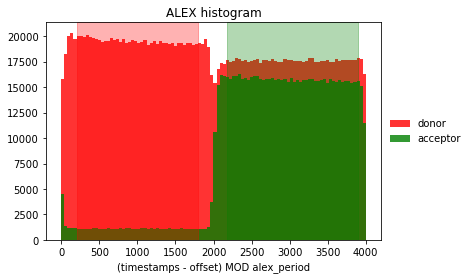

In [15]:
fig, ax = plt.subplots()
ax.hist((timestamps_acceptor - offset) % alex_period, bins=100, alpha=0.8, color='red', label='donor')
ax.hist((timestamps_donor - offset) % alex_period, bins=100, alpha=0.8, color='green', label='acceptor')
ax.axvspan(donor_period[0], donor_period[1], alpha=0.3, color='green')
ax.axvspan(acceptor_period[0], acceptor_period[1], alpha=0.3, color='red')
ax.set_xlabel('(timestamps - offset) MOD alex_period')
ax.set_title('ALEX histogram')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

# 6. Timestamps in different excitation periods

We conclude by showing, as an example, how to create arrays of timestamps containing only donor or acceptor exitation photons.


In [16]:
timestamps_mod = (timestamps - offset) % alex_period
donor_excitation = (timestamps_mod < donor_period[1])*(timestamps_mod > donor_period[0])
acceptor_excitation = (timestamps_mod < acceptor_period[1])*(timestamps_mod > acceptor_period[0])
timestamps_Dex = timestamps[donor_excitation]
timestamps_Aex = timestamps[acceptor_excitation]

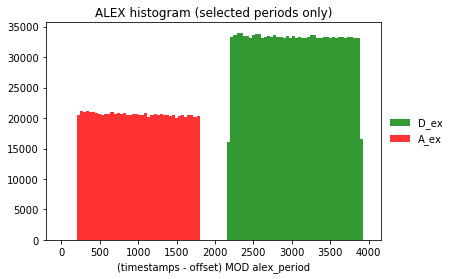

In [17]:
fig, ax = plt.subplots()
ax.hist((timestamps_Dex - offset) % alex_period, bins=np.arange(0, alex_period, 40), alpha=0.8, color='green', label='D_ex')
ax.hist((timestamps_Aex - offset) % alex_period, bins=np.arange(0, alex_period, 40), alpha=0.8, color='red', label='A_ex')
ax.set_xlabel('(timestamps - offset) MOD alex_period')
ax.set_title('ALEX histogram (selected periods only)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

In [18]:
#plt.close('all')